## Introduction
**This challenge is the capstone project of the Summer Analytics, a primer course on Data Science, conducted by Consulting and Analytics Club of IIT Guwahati in the summers.**

**The dataset is provided by DeltaX is the pioneering cross-channel digital advertising platform. The cloud-based platform leverages big data, user behavior, and machine learning algorithms to improve performance across the business funnel of advertisers.**

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,10


## Reading and exploring dataset

In [2]:
train_df=pd.read_csv('../input/revenue-generated-by-advertisements/Train_Data.csv')
test_df=pd.read_csv('../input/revenue-generated-by-advertisements/Test_Data.csv')

In [3]:
train_df.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [4]:
test_df.head()

,date,campaign,adgroup,ad,cost,impressions,clicks,conversions
0,01-03-2021,campaign 1,adgroup 1,ad 1,0.58,121,49,1
1,01-03-2021,campaign 1,adgroup 3,ad 1,0.17,22,12,0
2,01-03-2021,campaign 1,adgroup 4,ad 1,0.05,5,3,0
3,01-03-2021,campaign 1,adgroup 2,ad 1,0.01,2,1,0
4,01-03-2021,campaign 1,adgroup 2,ad 2,0.01,3,1,0


In [5]:
train_df.shape,test_df.shape

((4571, 9), (318, 8))

In [6]:
# Adding test and traing flag so that we can split train/test data
train_df['tst']=0
test_df['tst']=1

In [7]:
# concatenating train and test data for data preprocessing
data=pd.concat([train_df,test_df],axis=0,copy=True)
data.head()
df = data.copy()

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
impressions,4889.0,90.977705,193.610988,1.0,5.00,16.00,85.00,3239.00
clicks,4889.0,42.454899,97.591346,0.0,2.00,7.00,38.00,1771.00
cost,4889.0,2.643461,13.900229,0.0,0.04,0.19,1.26,531.25
conversions,4889.0,1.304357,5.073662,0.0,0.00,0.00,1.00,94.00
revenue,4571.0,231.865340,1091.742763,0.0,0.00,0.00,92.60,20515.41
tst,4889.0,0.065044,0.246629,0.0,0.00,0.00,0.00,1.00


In [9]:
df.isna().sum()

date             0
campaign         0
adgroup          0
ad               0
impressions      0
clicks           0
cost             0
conversions      0
revenue        318
tst              0
dtype: int64

In [10]:
df[(df.conversions==0) & (df.tst==0)].shape
df

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,0
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,0
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,0
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,0
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,0
...,...,...,...,...,...,...,...,...,...,...
313,15-03-2021,campaign 1,adgroup 4,ad 55,1,1,0.01,0,NaN,1
314,15-03-2021,campaign 1,adgroup 3,ad 55,5,1,0.01,0,NaN,1
315,15-03-2021,campaign 1,adgroup 1,ad 55,25,11,0.14,0,NaN,1
316,15-03-2021,campaign 1,adgroup 3,ad 56,9,4,0.06,0,NaN,1


## Feature Engineering

In [11]:
data['day']=data['date'].apply(lambda x:x[0:2]).astype(int)

data['month']=data['date'].apply(lambda x:x[3:5]).astype(int)

data['year']=pd.DatetimeIndex(data['date']).year
data

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst,day,month,year
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,0,1,8,2020
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,0,1,8,2020
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,0,1,8,2020
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,0,1,8,2020
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,0,1,8,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,15-03-2021,campaign 1,adgroup 4,ad 55,1,1,0.01,0,NaN,1,15,3,2021
314,15-03-2021,campaign 1,adgroup 3,ad 55,5,1,0.01,0,NaN,1,15,3,2021
315,15-03-2021,campaign 1,adgroup 1,ad 55,25,11,0.14,0,NaN,1,15,3,2021
316,15-03-2021,campaign 1,adgroup 3,ad 56,9,4,0.06,0,NaN,1,15,3,2021


In [12]:
data.shape
df=data.copy()
df

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst,day,month,year
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,0,1,8,2020
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,0,1,8,2020
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,0,1,8,2020
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,0,1,8,2020
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,0,1,8,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,15-03-2021,campaign 1,adgroup 4,ad 55,1,1,0.01,0,NaN,1,15,3,2021
314,15-03-2021,campaign 1,adgroup 3,ad 55,5,1,0.01,0,NaN,1,15,3,2021
315,15-03-2021,campaign 1,adgroup 1,ad 55,25,11,0.14,0,NaN,1,15,3,2021
316,15-03-2021,campaign 1,adgroup 3,ad 56,9,4,0.06,0,NaN,1,15,3,2021


In [13]:
#df['date'] = pd.to_datetime(df.date,format='%d-%m-%Y')
#df.index = df['date']

In [14]:
df['CPC']=df.cost.divide(df.clicks).replace(np.inf,0).replace(np.nan,0)
df['CTR']=df.clicks.divide(df.impressions).replace(np.inf,0).replace(np.nan,0)
df['COA']=df.cost.divide(df.conversions).replace(np.inf,0).replace(np.nan,0)


In [15]:
# don't run this
# df.drop(columns=['date'],axis=1,inplace=True)
# df['ROI']=df[df.tst==0].revenue.divide(df[df.tst==0].cost).replace(np.inf,0).replace(np.nan,0)

In [16]:
df['ad']=df['ad'].str.slice(3).astype(int)

df['adgroup']=df['adgroup'].str.slice(8).astype(int)

df['campaign']=df['campaign'].str.slice(-1).astype(int)

df.reset_index()

,index,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst,day,month,year,CPC,CTR,COA
0,0,01-08-2020,1,1,1,24,6,0.08,0,0.00,0,1,8,2020,0.013333,0.250000,0.0000
1,1,01-08-2020,1,2,1,1,0,0.00,0,0.00,0,1,8,2020,0.000000,0.000000,0.0000
2,2,01-08-2020,1,3,1,13,4,0.04,0,0.00,0,1,8,2020,0.010000,0.307692,0.0000
3,3,01-08-2020,1,4,1,5,4,0.08,0,0.00,0,1,8,2020,0.020000,0.800000,0.0000
4,4,01-08-2020,1,1,2,247,126,1.29,4,925.71,0,1,8,2020,0.010238,0.510121,0.3225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4884,313,15-03-2021,1,4,55,1,1,0.01,0,NaN,1,15,3,2021,0.010000,1.000000,0.0000
4885,314,15-03-2021,1,3,55,5,1,0.01,0,NaN,1,15,3,2021,0.010000,0.200000,0.0000
4886,315,15-03-2021,1,1,55,25,11,0.14,0,NaN,1,15,3,2021,0.012727,0.440000,0.0000
4887,316,15-03-2021,1,3,56,9,4,0.06,0,NaN,1,15,3,2021,0.015000,0.444444,0.0000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4889 entries, 0 to 317
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         4889 non-null   object 
 1   campaign     4889 non-null   int64  
 2   adgroup      4889 non-null   int64  
 3   ad           4889 non-null   int64  
 4   impressions  4889 non-null   int64  
 5   clicks       4889 non-null   int64  
 6   cost         4889 non-null   float64
 7   conversions  4889 non-null   int64  
 8   revenue      4571 non-null   float64
 9   tst          4889 non-null   int64  
 10  day          4889 non-null   int64  
 11  month        4889 non-null   int64  
 12  year         4889 non-null   int64  
 13  CPC          4889 non-null   float64
 14  CTR          4889 non-null   float64
 15  COA          4889 non-null   float64
dtypes: float64(5), int64(10), object(1)
memory usage: 649.3+ KB


In [18]:
df.month.unique()

array([ 8,  9, 10, 11, 12,  1,  2,  3])

## Exploratory Data Analysis

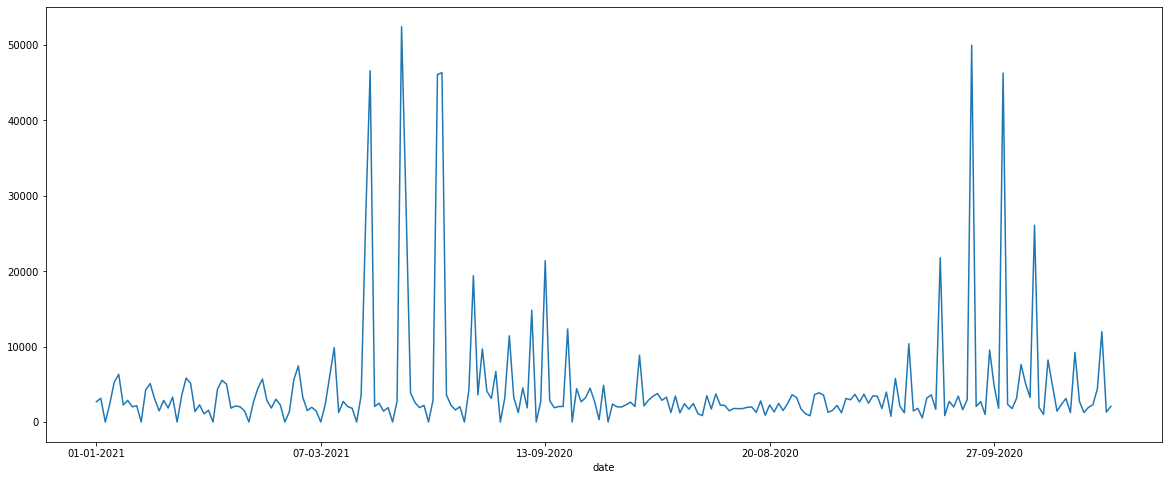

In [19]:
#Time series view
plt.figure(figsize=(20,8))
df.groupby(['date'])['revenue'].sum().plot(kind='line')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


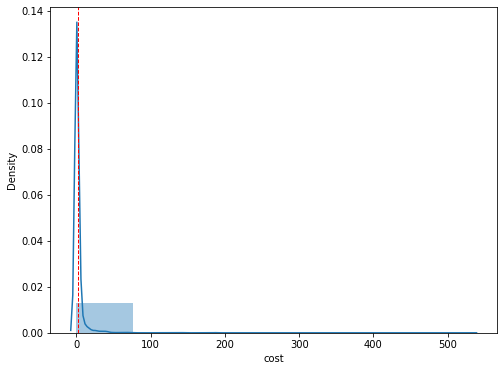

In [20]:
plt.figure(figsize=(8,6))
#plt.hist(df.cost,bins=7,density=True)
sns.distplot(df.cost,bins=7)
plt.axvline(df.cost.mean(), color='r', linestyle='dashed', linewidth=1)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


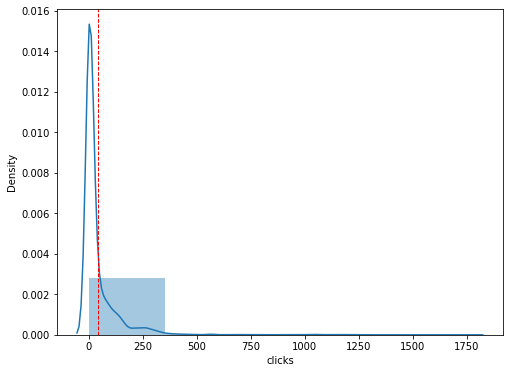

In [21]:
plt.figure(figsize=(8,6))
sns.distplot(df.clicks,bins=5)
plt.axvline(df.clicks.mean(), color='r', linestyle='dashed', linewidth=1)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


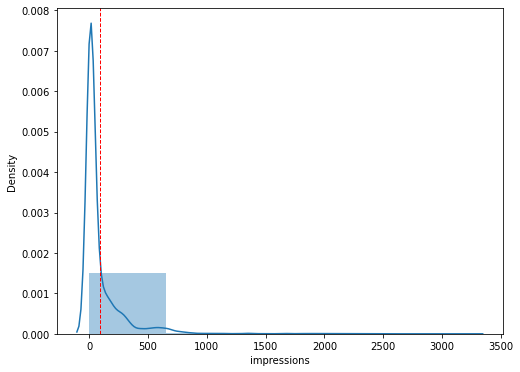

In [22]:
plt.figure(figsize=(8,6))
sns.distplot(df.impressions,bins=5)
plt.axvline(df.impressions.mean(), color='r', linestyle='dashed', linewidth=1)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


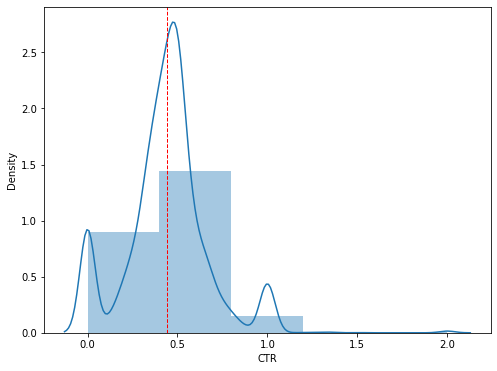

In [23]:
plt.figure(figsize=(8,6))
sns.distplot(df.CTR,bins=5)
plt.axvline(df.CTR.mean(), color='r', linestyle='dashed', linewidth=1)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='month', ylabel='revenue'>

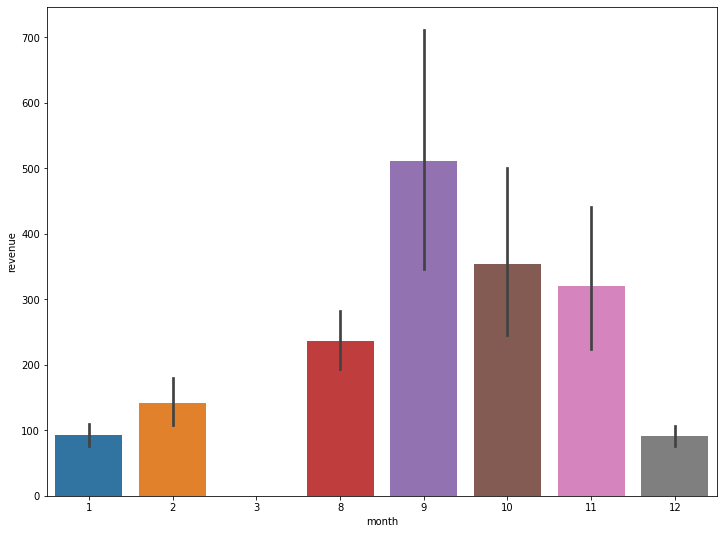

In [24]:

f, ax = plt.subplots(figsize=(12, 9));
sns.barplot('month','revenue',data=df)

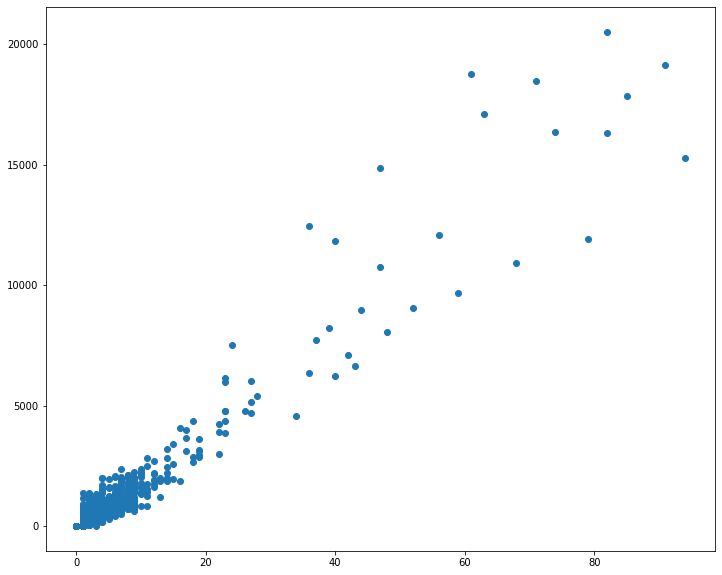

In [25]:
plt.scatter(df.conversions,df.revenue)
plt.show()

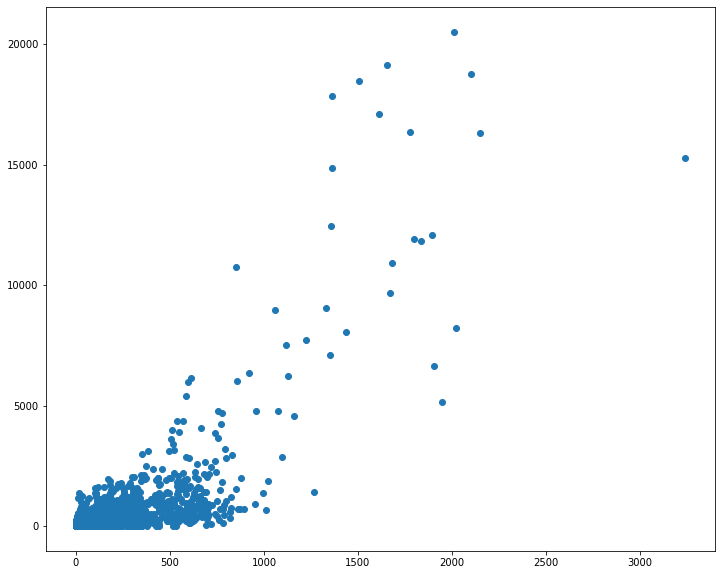

In [26]:
plt.scatter(df.impressions,df.revenue)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='adgroup', ylabel='revenue'>

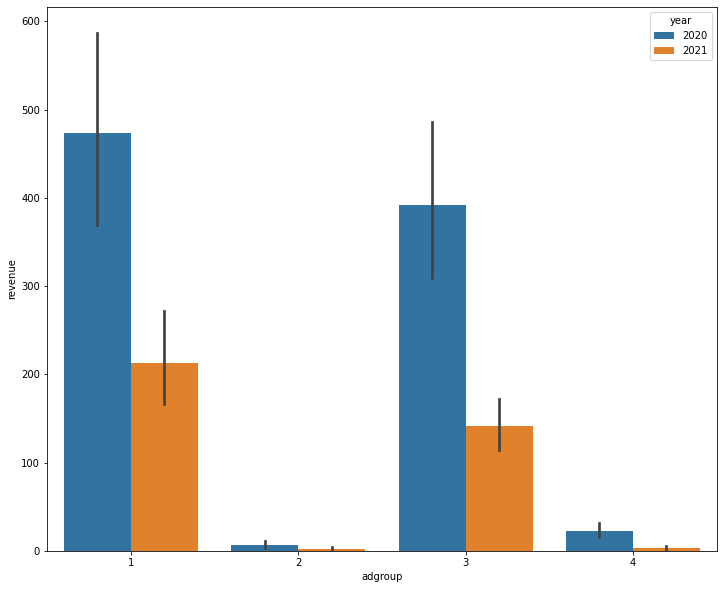

In [27]:
sns.barplot('adgroup','revenue',data=df,hue='year')

In [28]:
df.groupby(['date','adgroup'])['revenue'].sum().sort_values(ascending=False)

date        adgroup
10-10-2020  3          31765.46
26-11-2020  1          29398.31
09-09-2020  3          26956.77
27-11-2020  1          25685.71
09-09-2020  1          24911.10
                         ...   
15-08-2020  2              0.00
15-03-2021  4              0.00
            3              0.00
            2              0.00
31-12-2020  4              0.00
Name: revenue, Length: 908, dtype: float64

In [29]:
list(df.select_dtypes(exclude = ['object','datetime']).drop(columns=['revenue','tst']).columns)

['campaign',
 'adgroup',
 'ad',
 'impressions',
 'clicks',
 'cost',
 'conversions',
 'day',
 'month',
 'year',
 'CPC',
 'CTR',
 'COA']

In [30]:
df_copy=df.copy()


## Feature Trnsformation and Scaling

In [31]:
str_col=['ad','adgroup','campaign','year','month','day','date']
le=LabelEncoder()
for col in str_col:
    df[col]=le.fit_transform(df[col].values)

In [32]:
df.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,tst,day,month,year,CPC,CTR,COA
0,3,0,0,0,24,6,0.08,0,0.00,0,0,3,0,0.013333,0.250000,0.0000
1,3,0,1,0,1,0,0.00,0,0.00,0,0,3,0,0.000000,0.000000,0.0000
2,3,0,2,0,13,4,0.04,0,0.00,0,0,3,0,0.010000,0.307692,0.0000
3,3,0,3,0,5,4,0.08,0,0.00,0,0,3,0,0.020000,0.800000,0.0000
4,3,0,0,1,247,126,1.29,4,925.71,0,0,3,0,0.010238,0.510121,0.3225


In [33]:
sc=MinMaxScaler()
num_col=list(df.select_dtypes(exclude = ['object']).drop(columns=['revenue','tst']).columns)
df_scaled=sc.fit_transform(df[num_col].values)

In [34]:
df_scaled=pd.DataFrame(df_scaled,columns=num_col)
df_scaled.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,day,month,year,CPC,CTR,COA
0,0.013274,0.0,0.000000,0.000000,0.007103,0.003388,0.000151,0.000000,0.0,0.428571,0.0,0.003500,0.125000,0.000000
1,0.013274,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.428571,0.0,0.000000,0.000000,0.000000
2,0.013274,0.0,0.666667,0.000000,0.003706,0.002259,0.000075,0.000000,0.0,0.428571,0.0,0.002625,0.153846,0.000000
3,0.013274,0.0,1.000000,0.000000,0.001235,0.002259,0.000151,0.000000,0.0,0.428571,0.0,0.005249,0.400000,0.000000
4,0.013274,0.0,0.000000,0.013514,0.075973,0.071146,0.002428,0.042553,0.0,0.428571,0.0,0.002687,0.255061,0.005614


In [35]:
df[num_col]

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,day,month,year,CPC,CTR,COA
0,3,0,0,0,24,6,0.08,0,0,3,0,0.013333,0.250000,0.0000
1,3,0,1,0,1,0,0.00,0,0,3,0,0.000000,0.000000,0.0000
2,3,0,2,0,13,4,0.04,0,0,3,0,0.010000,0.307692,0.0000
3,3,0,3,0,5,4,0.08,0,0,3,0,0.020000,0.800000,0.0000
4,3,0,0,1,247,126,1.29,4,0,3,0,0.010238,0.510121,0.3225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,114,0,3,54,1,1,0.01,0,14,2,1,0.010000,1.000000,0.0000
314,114,0,2,54,5,1,0.01,0,14,2,1,0.010000,0.200000,0.0000
315,114,0,0,54,25,11,0.14,0,14,2,1,0.012727,0.440000,0.0000
316,114,0,2,55,9,4,0.06,0,14,2,1,0.015000,0.444444,0.0000


In [36]:
train=df[df.tst==0]
test=df[df.tst==1]

In [37]:
train=train.drop(columns=['tst','campaign'],axis=1)

In [38]:
test=test.drop(columns=['tst','revenue','campaign'],axis=1)
test

,date,adgroup,ad,impressions,clicks,cost,conversions,day,month,year,CPC,CTR,COA
0,2,0,0,121,49,0.58,1,0,2,1,0.011837,0.404959,0.58
1,2,2,0,22,12,0.17,0,0,2,1,0.014167,0.545455,0.00
2,2,3,0,5,3,0.05,0,0,2,1,0.016667,0.600000,0.00
3,2,1,0,2,1,0.01,0,0,2,1,0.010000,0.500000,0.00
4,2,1,1,3,1,0.01,0,0,2,1,0.010000,0.333333,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,114,3,54,1,1,0.01,0,14,2,1,0.010000,1.000000,0.00
314,114,2,54,5,1,0.01,0,14,2,1,0.010000,0.200000,0.00
315,114,0,54,25,11,0.14,0,14,2,1,0.012727,0.440000,0.00
316,114,2,55,9,4,0.06,0,14,2,1,0.015000,0.444444,0.00


In [39]:
X=train.columns.drop('revenue')
y=train.revenue
X

Index(['date', 'adgroup', 'ad', 'impressions', 'clicks', 'cost', 'conversions',
       'day', 'month', 'year', 'CPC', 'CTR', 'COA'],
      dtype='object')

## Feature Selection

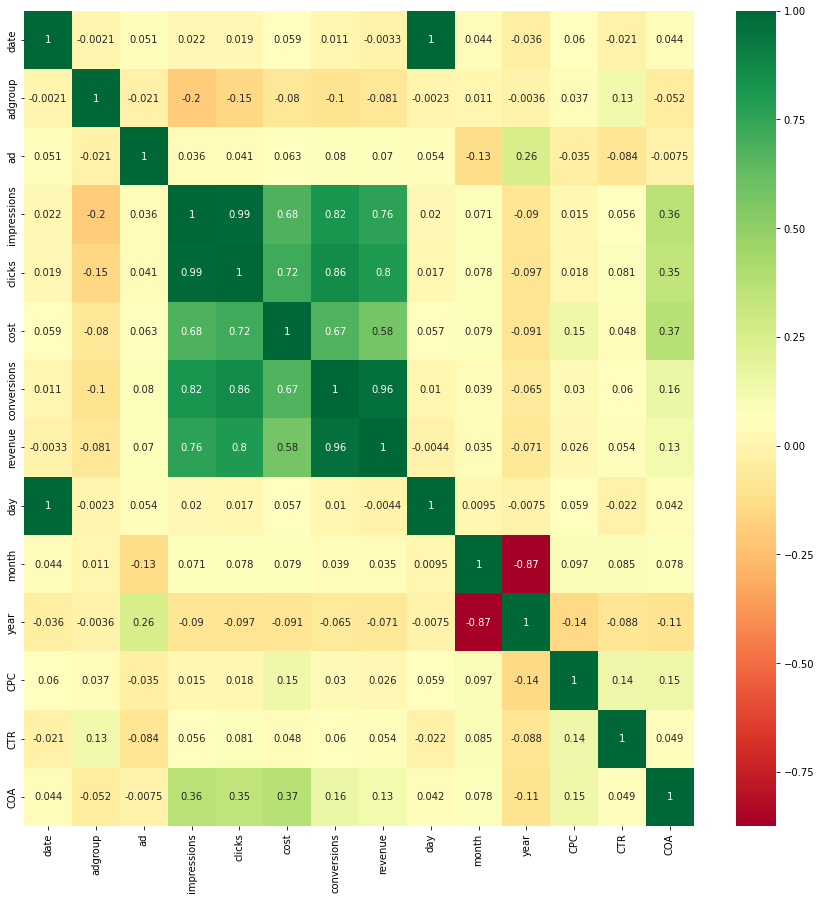

In [40]:
plt.figure(figsize=(15,15))
corrmat =train.corr()
top_corr_features = corrmat.index

#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#sns.heatmap(train.corr(),annot=True)
plt.show()


In [41]:
train[X].var().sort_values(ascending=False)

impressions    39342.618057
clicks         10033.009839
date            4311.428828
ad               373.424930
cost             206.256076
day               77.234203
conversions       27.289366
month              6.358523
COA                4.044536
adgroup            1.198460
year               0.212179
CTR                0.053852
CPC                0.018230
dtype: float64

In [42]:
#features=['COA','cost','conversions','adgroup','clicks','CPC']---v5.0
#features=['conversions','adgroup','date','clicks','year']---v11.0
features=['date', 'adgroup', 'ad', 'impressions', 'clicks', 'cost', 'conversions',
       'day', 'month', 'year', 'CPC', 'CTR', 'COA']  # replaced impression->cost
X=train[features]
y=train.revenue

## Train Test Split

In [43]:
# Since the given data is time series,we will not split on random basis...splitting data contigously
row=3320
X_train=X[:row]
X_val=X[row:]
y_train=y[:row]
y_val=y[row:]

In [44]:
X_test=test[features]

In [45]:
X_train.shape,y_val.shape

((3320, 13), (1251,))

## Model Building and Evaluation

In [46]:
def score(model,test,name='default'):
    model.fit(X_train,y_train)
    ypred=model.predict(test)
    print(name)
    print('Accuracy of training set: ',round(model.score(X_train,y_train)*100,2))
    print('Accuracy of test set: ',round(model.score(test,y_val)*100,2))
    print('mean squared error: ',round(mean_squared_error(y_val,ypred)/100,2))
    print('mean absolute error: ',round(mean_absolute_error(y_val,ypred),2))
    print('r2_score: ',round(r2_score(y_val,ypred)*100,2))

## 1. Linear Regresion

In [47]:
le=LinearRegression()
score(le,X_val,name='Linear Regression')

Linear Regression
Accuracy of training set:  94.64
Accuracy of test set:  73.89
mean squared error:  371.98
mean absolute error:  113.54
r2_score:  73.89


In [48]:
le.fit(X_train,y_train)
ypred=le.predict(test[features])
preds=le.predict(X_val)

In [49]:
ypred_df=pd.DataFrame(ypred,columns=['revenue'])

In [50]:
ypred_df

,revenue
0,106.940529
1,-84.390654
2,-78.341146
3,-83.912851
4,-77.342295
...,...
313,-84.852503
314,-59.229409
315,-83.488769
316,-68.456949


In [51]:
train[features][:row].shape

(3320, 13)

## 2. XGBoost Algorithm

In [52]:
# Best hyperparameters

xgb=XGBRegressor(n_estimators=37,learning_rate=0.05,booster='gbtree')
xgb.fit(X_train,y_train)

score(xgb,X_val,name='XG Boost')

XG Boost
Accuracy of training set:  95.01
Accuracy of test set:  91.0
mean squared error:  128.17
mean absolute error:  39.9
r2_score:  91.0


In [53]:
ypred=xgb.predict(X_test)
preds=xgb.predict(X_val)

In [54]:
ypred_df=pd.DataFrame(ypred,columns=['revenue'])

In [55]:
ypred_df.index=test.index
ypred_df.head(10)

,revenue
0,147.545273
1,0.075009
2,0.075009
3,0.075009
4,0.075009
5,0.075009
6,181.880661
7,0.075009
8,147.545273
9,0.075009


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


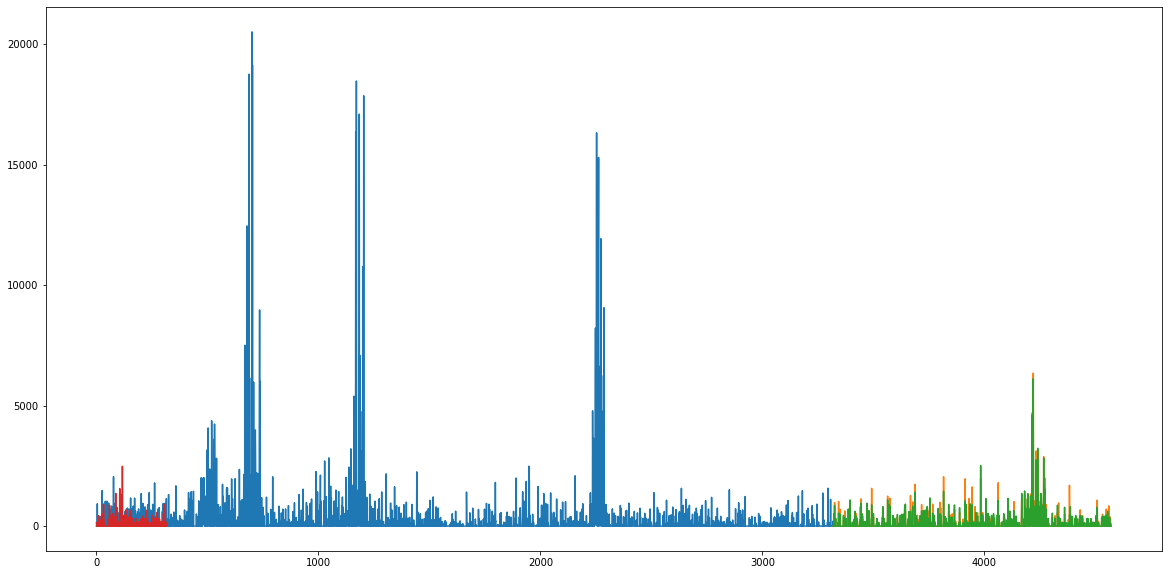

In [56]:
plt.figure(figsize=(20,10))
valid=train[row:]
valid['Predictions'] = 0
valid['Predictions'] = preds
train1=train[features][:row]
valid.index = train[features][row:].index
train1.index = train1[:row].index

plt.plot(train['revenue'][:row]) # train set
plt.plot(valid[['revenue', 'Predictions']]) # val set
plt.plot(ypred_df.revenue) # test set
plt.show()

In [57]:
#use this to find optimum value of n
mse=[]
mae=[]
for i in range(10,60):
    xgb=XGBRegressor(n_estimators=i,learning_rate=0.05)
    xgb.fit(X_train,y_train)
    pr=xgb.predict(X_val)
    ms=mean_squared_error(y_val,pr)
    ma=mean_absolute_error(y_val,pr)
    mse.append(ms)
    mae.append(ma)

In [58]:
10+mae.index(min(mae))

30

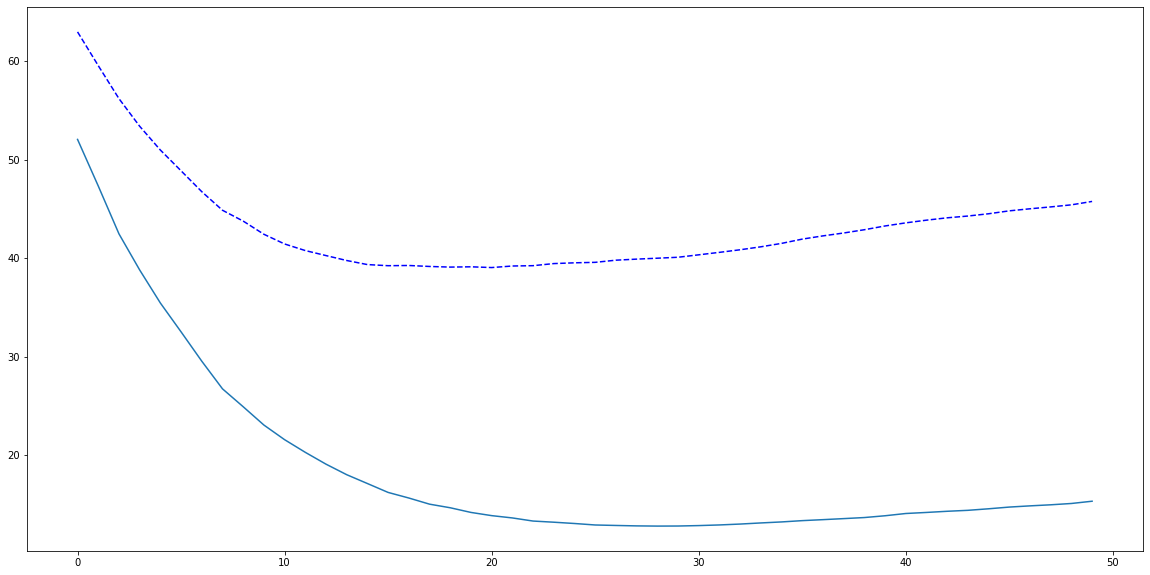

In [59]:
plt.figure(figsize=(20,10))
plt.plot(np.array(mae),'b--')
plt.plot(np.array(mse)/1000)
plt.show()

In [60]:
 xgb_model = XGBRegressor(
         objective = 'reg:squarederror',
         colsample_bytree = 0.7,
         learning_rate = 0.1,
         max_depth = 3,
         min_child_weight = 3,
         n_estimators = 60,
         subsample = 0.7)

 %time xgb_model.fit(X_train, y_train, early_stopping_rounds=7, eval_set=[(X_val, y_val)], verbose=False)

 y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb1 = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

 print("MAE: ", mae_xgb)
score(xgb_model,X_val,name='XG Boost')

CPU times: user 107 ms, sys: 78 µs, total: 107 ms
Wall time: 55.4 ms
MAE:  42.78450200039134
XG Boost
Accuracy of training set:  98.62
Accuracy of test set:  88.0
mean squared error:  170.97
mean absolute error:  51.46
r2_score:  88.0


#  HyperTuning

In [61]:
 def hyperParameterTuning(X_train, y_train):
        param_tuning = {
         'learning_rate': [0.01, 0.1,0.05],
        'max_depth': [3, 5, 7, 10],
         'min_child_weight': [1, 3, 5],
         'subsample': [0.5, 0.7],
         'colsample_bytree': [0.5, 0.7],
         'n_estimators' : [40, 50, 60],
         'objective': ['reg:squarederror']
     }

        xgb_model = XGBRegressor()

        gsearch = GridSearchCV(estimator = xgb_model,
                            param_grid = param_tuning,                        
                            #scoring = 'neg_mean_absolute_error', #MAE
                            #scoring = 'neg_mean_squared_error',  #MSE
                            cv = 5,
                            n_jobs = -1,
                            verbose = 1)

        gsearch.fit(X_train,y_train)
        ypred=gsearch.predict(X_val)
        ypred_1=gsearch.predict(X_test)
        
        print('Accuracy of training set: ',round(gsearch.score(X_train,y_train)*100,2))
        print('Accuracy of test set: ',round(gsearch.score(X_val,y_val)*100,2))
        print('mean squared error: ',round(mean_squared_error(y_val,ypred)/100,2))
        print('mean absolute error: ',round(mean_absolute_error(y_val,ypred),2))
        print('r2_score: ',round(r2_score(y_val,ypred)*100,2))
        return ypred_1
        

In [62]:
 ypred_1 = hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 17.6min finished


Accuracy of training set:  95.58
Accuracy of test set:  88.79
mean squared error:  159.66
mean absolute error:  43.16
r2_score:  88.79


In [63]:
ypred2_df=pd.DataFrame(ypred_1,columns=['revenue'])
ypred2_df.to_csv('Submission_GridSearch.csv',index=False)

# Optuna HyperTuning


In [64]:
import optuna
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
dtrain = xgb.DMatrix(X_train,y_train)
dtest  = xgb.DMatrix(X_val,y_val)

In [65]:
def objective(trial):
   
    param = {
#               
                'max_depth':trial.suggest_int('max_depth', 0,12 ),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0.5,5),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0,5),
                'min_child_weight':trial.suggest_int('min_child_weight',0,4),
                'gamma':trial.suggest_uniform('gamma', 1,8 ),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.15,2),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.1,1),
                'subsample':trial.suggest_uniform('subsample',0.05,1),

                'nthread' : -1
            }
    return(return_rmse(param)) # this will return the rmse score 

In [66]:
import re
def return_rmse(params):
    model = xgb.train(params , dtrain, num_boost_round = 60, evals = [(dtest, 'eval')],
          early_stopping_rounds=20,verbose_eval = 0)
    result = model.eval(dtest)
    result = np.float(re.search(r'[\d.]+$',result).group(0))
    print(result)
    return(result)

In [67]:
study1 = optuna.create_study(direction='minimize',sampler=TPESampler())
study1.optimize(objective, n_trials= 60,show_progress_bar = True)

[I 2021-10-26 11:04:43,145] A new study created in memory with name: no-name-8e125e3b-88df-4a20-aeb5-fd0b63b044a7
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/60 [00:00<?, ?it/s]

140.622849
[I 2021-10-26 11:04:43,323] Trial 0 finished with value: 140.622849 and parameters: {'max_depth': 9, 'reg_alpha': 4.155386754970454, 'reg_lambda': 2.5491777620591587, 'min_child_weight': 0, 'gamma': 3.7578416912835477, 'learning_rate': 0.3518039388234584, 'colsample_bytree': 0.9808201371084493, 'subsample': 0.6715160413301605}. Best is trial 0 with value: 140.622849.
243.474579
[I 2021-10-26 11:04:43,355] Trial 1 finished with value: 243.474579 and parameters: {'max_depth': 3, 'reg_alpha': 4.291365266505026, 'reg_lambda': 0.49596982441181936, 'min_child_weight': 2, 'gamma': 5.018910498731874, 'learning_rate': 0.19720675159606246, 'colsample_bytree': 0.24560536748669753, 'subsample': 0.05744630807707196}. Best is trial 0 with value: 140.622849.
1005.147949
[I 2021-10-26 11:04:43,444] Trial 2 finished with value: 1005.147949 and parameters: {'max_depth': 12, 'reg_alpha': 3.702782174988575, 'reg_lambda': 1.0433262918589454, 'min_child_weight': 0, 'gamma': 6.463164244835753, 'le

In [68]:
study1.best_params
#model(study1.best_params)

{'max_depth': 4,
 'reg_alpha': 1.7151115100423326,
 'reg_lambda': 3.504473444616354,
 'min_child_weight': 4,
 'gamma': 1.516680386024401,
 'learning_rate': 0.24991936774498177,
 'colsample_bytree': 0.5353562933586852,
 'subsample': 0.42229038805554275}

In [69]:
optuna.visualization.plot_optimization_history(study1)

In [70]:
optuna.visualization.plot_slice(study1)

In [71]:
xgb_model = XGBRegressor(**(study1.best_params))

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=7, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb2 = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print("MAE: ", mae_xgb)
score(xgb_model,X_val,name='XG Boost')

CPU times: user 83.3 ms, sys: 875 µs, total: 84.1 ms
Wall time: 46.6 ms
MAE:  43.905730835939764
XG Boost
Accuracy of training set:  99.18
Accuracy of test set:  89.05
mean squared error:  155.92
mean absolute error:  53.14
r2_score:  89.05


In [72]:
ypred2_df=pd.DataFrame(y_pred_xgb2,columns=['revenue'])
ypred2_df.to_csv('Submission_optuna.csv',index=False)

##  Random Forest Regressor

In [73]:
rf=RandomForestRegressor(n_estimators=25,max_depth=5)
rf.fit(X_train,y_train)
ypredrf=rf.predict(test[features])
score(rf,X_val,name='Random Forest')

Random Forest
Accuracy of training set:  97.95
Accuracy of test set:  81.91
mean squared error:  257.74
mean absolute error:  49.62
r2_score:  81.91


In [74]:
ypred_df=pd.DataFrame(ypredrf,columns=['revenue'])
ypred_df.head(10)

,revenue
0,172.202095
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,174.589696
7,0.000000
8,174.589696
9,0.000000


In [75]:
ypred_df.to_csv('Submission_RF.csv',index=False)